#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/kt/projects_kt/project_6/6/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [ ]:
oil_price.head()

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


In [ ]:
df1 = pd.merge(sales, products, on = 'Product_ID', how = 'outer')
df2 = pd.merge(df1, stores, on = 'Store_ID', how = 'outer')
df3 = pd.merge(df2, oil_price, on = 'Date', how = 'outer')
merged_data = pd.merge(df3, orders, on = ['Date', 'Store_ID'], how = 'outer')
print(merged_data.shape)
merged_data.dropna(inplace = True)
print(merged_data.shape)
merged_data.head()

(934275, 14)
(599054, 14)


,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,WTI_Price,CustomerCount
811,2014-01-02,1,2524.000,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,95.14,1875.0
812,2014-01-02,1,388.988,5,FB001,BAKERY,Food,2,6,Saint Paul,\tMinnesota,4,95.14,1875.0
813,2014-01-02,1,852.000,7,HC001,Cleaning,Household Goods,2,15,Saint Paul,\tMinnesota,4,95.14,1875.0
814,2014-01-02,1,772.000,8,FM001,Yogurt,Food,2,4,Saint Paul,\tMinnesota,4,95.14,1875.0
815,2014-01-02,1,195.000,10,GE001,EGGS,Grocery,2,5,Saint Paul,\tMinnesota,4,95.14,1875.0


## **(1) 상품 : 3 - Beverage**

In [ ]:
data_beverage = merged_data[merged_data['Product_ID'] == 3]
data_beverage.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,WTI_Price,CustomerCount
811,2014-01-02,1,2524.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,95.14,1875.0
826,2014-01-02,2,3190.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,95.14,2122.0
841,2014-01-02,3,9136.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,95.14,3350.0
856,2014-01-02,4,3231.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,95.14,1661.0
871,2014-01-02,5,2766.0,3,DB001,Beverage,Drink,2,8,Oklahoma City,Oklahoma,4,95.14,1807.0


In [ ]:
# 날짜별로 Qty 합산하고 WTI_Price 평균 계산
data_beverage_grouped = data_beverage.groupby('Date').agg({
    'Qty': 'sum',
    'WTI_Price': 'mean',
    'CustomerCount': 'sum'

}).reset_index()

# 결과 출력
data_beverage_grouped.head()


,Date,Qty,WTI_Price,CustomerCount
0,2014-01-02,172140.0,95.14,90716.0
1,2014-01-03,146684.0,93.66,84488.0
2,2014-01-06,134433.0,93.12,77784.0
3,2014-01-07,116379.0,93.31,75361.0
4,2014-01-08,126533.0,91.90,77204.0


In [ ]:
drop_cols = ['Product_ID', 'Product_Code','SubCategory','Category','Date','Price','LeadTime']
dumm_cols = ['State', 'City']

In [ ]:
data_beverage.drop(columns=drop_cols, axis=1, inplace=True)
data_beverage = pd.get_dummies(data_beverage, columns=dumm_cols, drop_first=True,dtype=int)
data_beverage.head()

,Store_ID,Qty,Store_Type,WTI_Price,CustomerCount,State_\tMinnesota,State_\tNorth Carolina,State_\tTennessee,State_Arizona,State_Georgia,...,City_Minneapolis,City_Nashville,City_Oklahoma City,City_Olympia,City_Phoenix,City_Raleigh,City_Richmond,City_Sacramento,City_Saint Paul,City_Wilmington
811,1,2524.0,4,95.14,1875.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
826,2,3190.0,4,95.14,2122.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
841,3,9136.0,4,95.14,3350.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
856,4,3231.0,4,95.14,1661.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
871,5,2766.0,4,95.14,1807.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## **(2) 상품 : 12 - Milk**

In [ ]:
data_food = merged_data[merged_data['Product_ID'] == 12]
data_food.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,WTI_Price,CustomerCount
817,2014-01-02,1,2441.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,4,95.14,1875.0
832,2014-01-02,2,3750.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,4,95.14,2122.0
847,2014-01-02,3,8659.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,4,95.14,3350.0
862,2014-01-02,4,3386.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,4,95.14,1661.0
877,2014-01-02,5,4627.0,12,GA001,Milk,Food,2,6,Oklahoma City,Oklahoma,4,95.14,1807.0


In [ ]:
# 날짜별로 Qty 합산하고 WTI_Price 평균 계산
data_food_grouped = data_food.groupby('Date').agg({
    'Qty': 'sum',
    'WTI_Price': 'mean',
    'CustomerCount': 'sum'

}).reset_index()

# 결과 출력
data_food_grouped.head()


,Date,Qty,WTI_Price,CustomerCount
0,2014-01-02,212240.551,95.14,90716.0
1,2014-01-03,179260.345,93.66,84488.0
2,2014-01-06,166233.668,93.12,77784.0
3,2014-01-07,151394.750,93.31,75361.0
4,2014-01-08,157935.234,91.90,77204.0


In [ ]:
drop_cols = ['Product_ID', 'Product_Code','SubCategory','Category','Date','Price','LeadTime']
dumm_cols = ['State', 'City']

In [ ]:
data_food.drop(columns=drop_cols, axis=1, inplace=True)
data_food = pd.get_dummies(data_food, columns=dumm_cols, drop_first=True,dtype=int)
data_food.head()

,Store_ID,Qty,Store_Type,WTI_Price,CustomerCount,State_\tMinnesota,State_\tNorth Carolina,State_\tTennessee,State_Arizona,State_Georgia,...,City_Minneapolis,City_Nashville,City_Oklahoma City,City_Olympia,City_Phoenix,City_Raleigh,City_Richmond,City_Sacramento,City_Saint Paul,City_Wilmington
817,1,2441.0,4,95.14,1875.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
832,2,3750.0,4,95.14,2122.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
847,3,8659.0,4,95.14,3350.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
862,4,3386.0,4,95.14,1661.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
877,5,4627.0,4,95.14,1807.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## **(3) 상품 : 42 - Agricultural products**

In [ ]:
data_grocery = merged_data[merged_data['Product_ID'] == 42]
data_grocery.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,WTI_Price,CustomerCount
1471,2014-01-02,44,76.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,95.14,4422.0
2282,2014-01-03,44,74.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,93.66,4167.0
4715,2014-01-06,44,65.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,93.12,3917.0
5526,2014-01-07,44,78.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,93.31,3663.0
6337,2014-01-08,44,73.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,91.90,4254.0


In [ ]:
# 날짜별로 Qty 합산하고 WTI_Price 평균 계산
data_grocery_grouped = data_grocery.groupby('Date').agg({
    'Qty': 'sum',
    'WTI_Price': 'mean',
    'CustomerCount': 'sum'
}).reset_index()

# 결과 출력
data_grocery_grouped.head()


,Date,Qty,WTI_Price,CustomerCount
0,2014-01-02,76.0,95.14,4422.0
1,2014-01-03,74.0,93.66,4167.0
2,2014-01-06,65.0,93.12,3917.0
3,2014-01-07,78.0,93.31,3663.0
4,2014-01-08,73.0,91.90,4254.0


In [ ]:
drop_cols = ['Product_ID', 'Product_Code','SubCategory','Category','Date','Price','LeadTime']
dumm_cols = ['State', 'City']

In [ ]:
data_grocery.drop(columns=drop_cols, axis=1, inplace=True)
data_grocery = pd.get_dummies(data_grocery, columns=dumm_cols, drop_first=True,dtype=int)
data_grocery.head()

,Store_ID,Qty,Store_Type,WTI_Price,CustomerCount
1471,44,76.0,1,95.14,4422.0
2282,44,74.0,1,93.66,4167.0
4715,44,65.0,1,93.12,3917.0
5526,44,78.0,1,93.31,3663.0
6337,44,73.0,1,91.90,4254.0


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
target = 'Qty'

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
x_beverage = data_beverage.drop(columns=target, axis=1)
y_beverage = data_beverage[target]

In [ ]:
x_beverage_train, x_beverage_test, y_beverage_train, y_beverage_test = train_test_split(x_beverage, y_beverage, test_size=0.2, shuffle=False, random_state=1)

In [ ]:
scaler_beverage = MinMaxScaler()
scaler_beverage.fit(x_beverage_train)
x_beverage_train = scaler_beverage.transform(x_beverage_train)
x_beverage_test = scaler_beverage.transform(x_beverage_test)

### **2) 모델링**

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Beverage Model Evaluation:
RMSE: 3352.088365553551
MAE: 2668.1169040235673
MAPE: 0.850848766135519
R2 Score: -1.6891073103791712


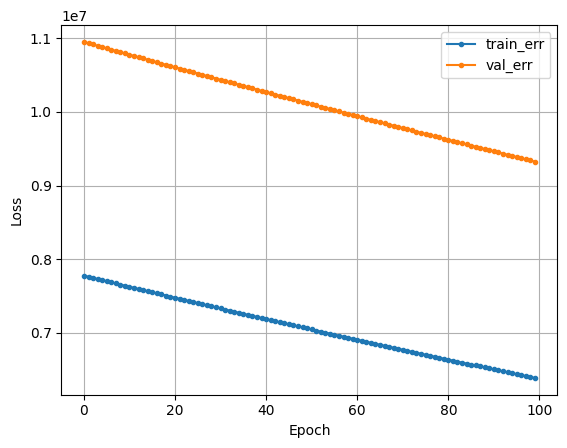

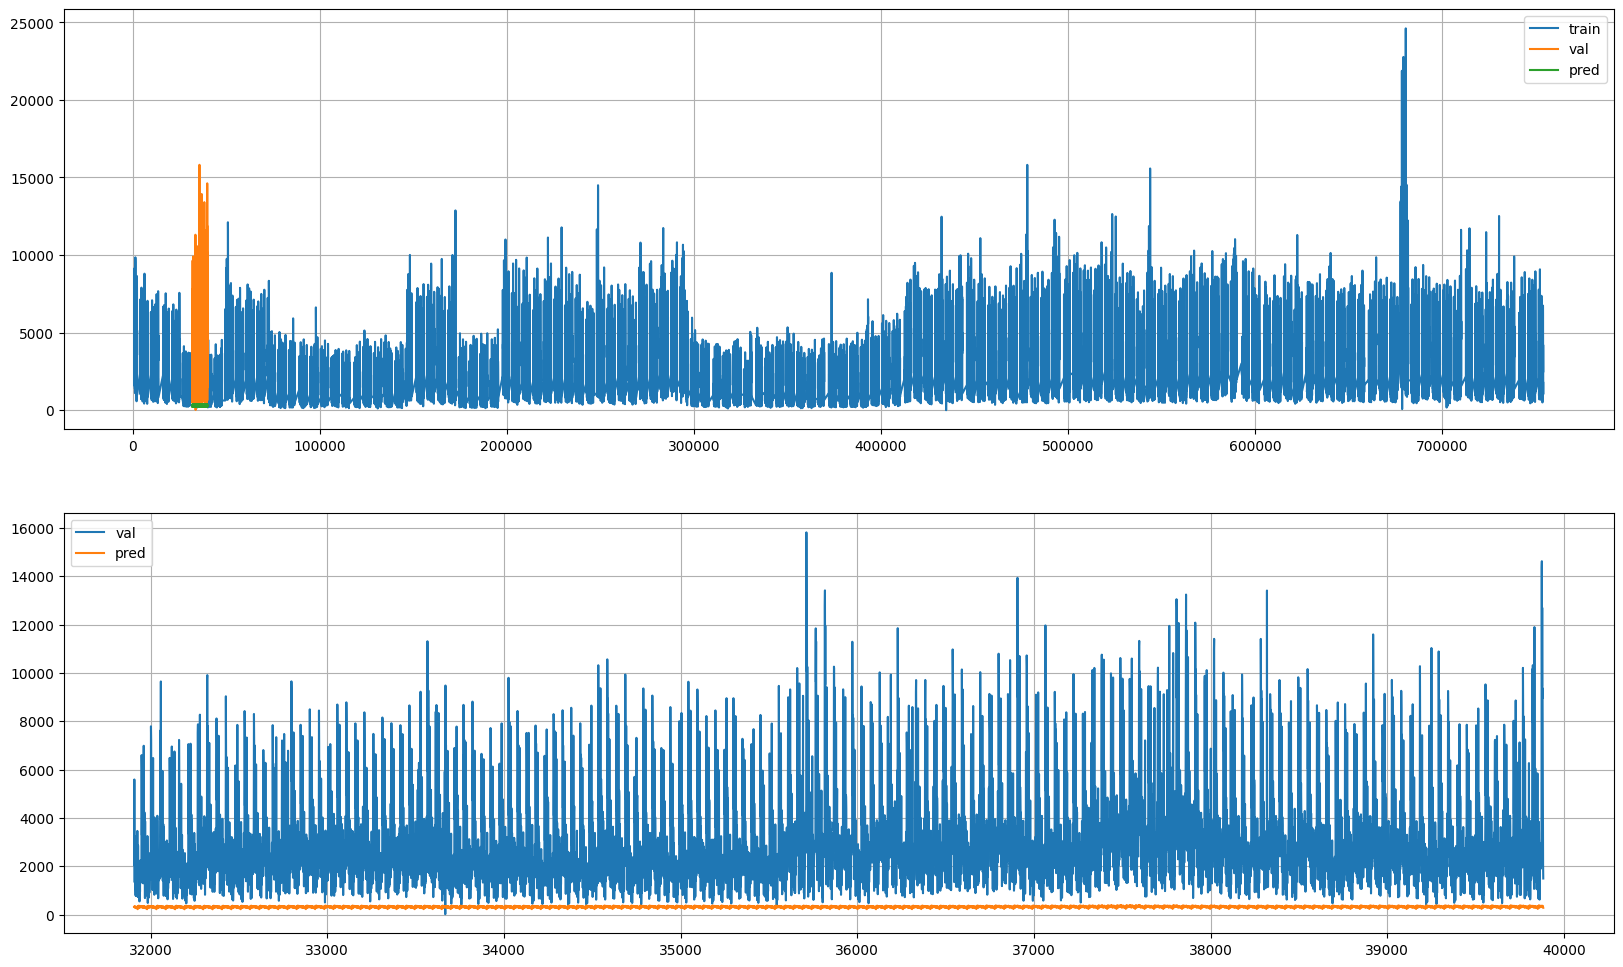

In [ ]:

# ### **2) 모델링**
clear_session()
model_beverage = Sequential()
model_beverage.add(Dense(1, input_dim=x_beverage_train.shape[1], activation='linear'))
model_beverage.compile(loss='mse', optimizer='adam')
history_beverage = model_beverage.fit(x_beverage_train, y_beverage_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_beverage_pred = model_beverage.predict(x_beverage_test)
y_beverage_pred = y_beverage_pred.reshape(-1,)
rmse_beverage = mean_squared_error(y_beverage_test, y_beverage_pred, squared=False)
mae_beverage = mean_absolute_error(y_beverage_test, y_beverage_pred)
mape_beverage = mean_absolute_percentage_error(y_beverage_test, y_beverage_pred)
r2_beverage = r2_score(y_beverage_test, y_beverage_pred)

print(f"Beverage Model Evaluation:")
print(f"RMSE: {rmse_beverage}")
print(f"MAE: {mae_beverage}")
print(f"MAPE: {mape_beverage}")
print(f"R2 Score: {r2_beverage}")

dl_history_plot(history_beverage.history)
plot_model_result(y_beverage_train, y_beverage_test, y_beverage_pred)



## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [ ]:
x_food = data_food.drop(columns=target, axis=1)
y_food = data_food[target]
x_food_train, x_food_test, y_food_train, y_food_test = train_test_split(x_food, y_food, test_size=0.2, shuffle=False, random_state=1)
scaler_food = MinMaxScaler()
scaler_food.fit(x_food_train)
x_food_train = scaler_food.transform(x_food_train)
x_food_test = scaler_food.transform(x_food_test)

### **2) 모델링**

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Food Model Evaluation:
RMSE: 4624.78327207965
MAE: 3869.919636511152
MAPE: 0.9119820633097111
R2 Score: -2.3031852076726187


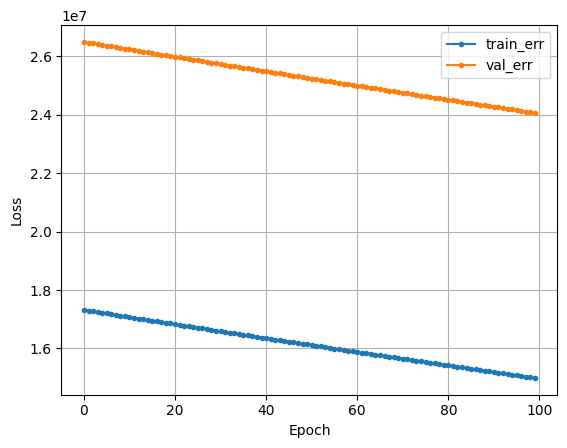

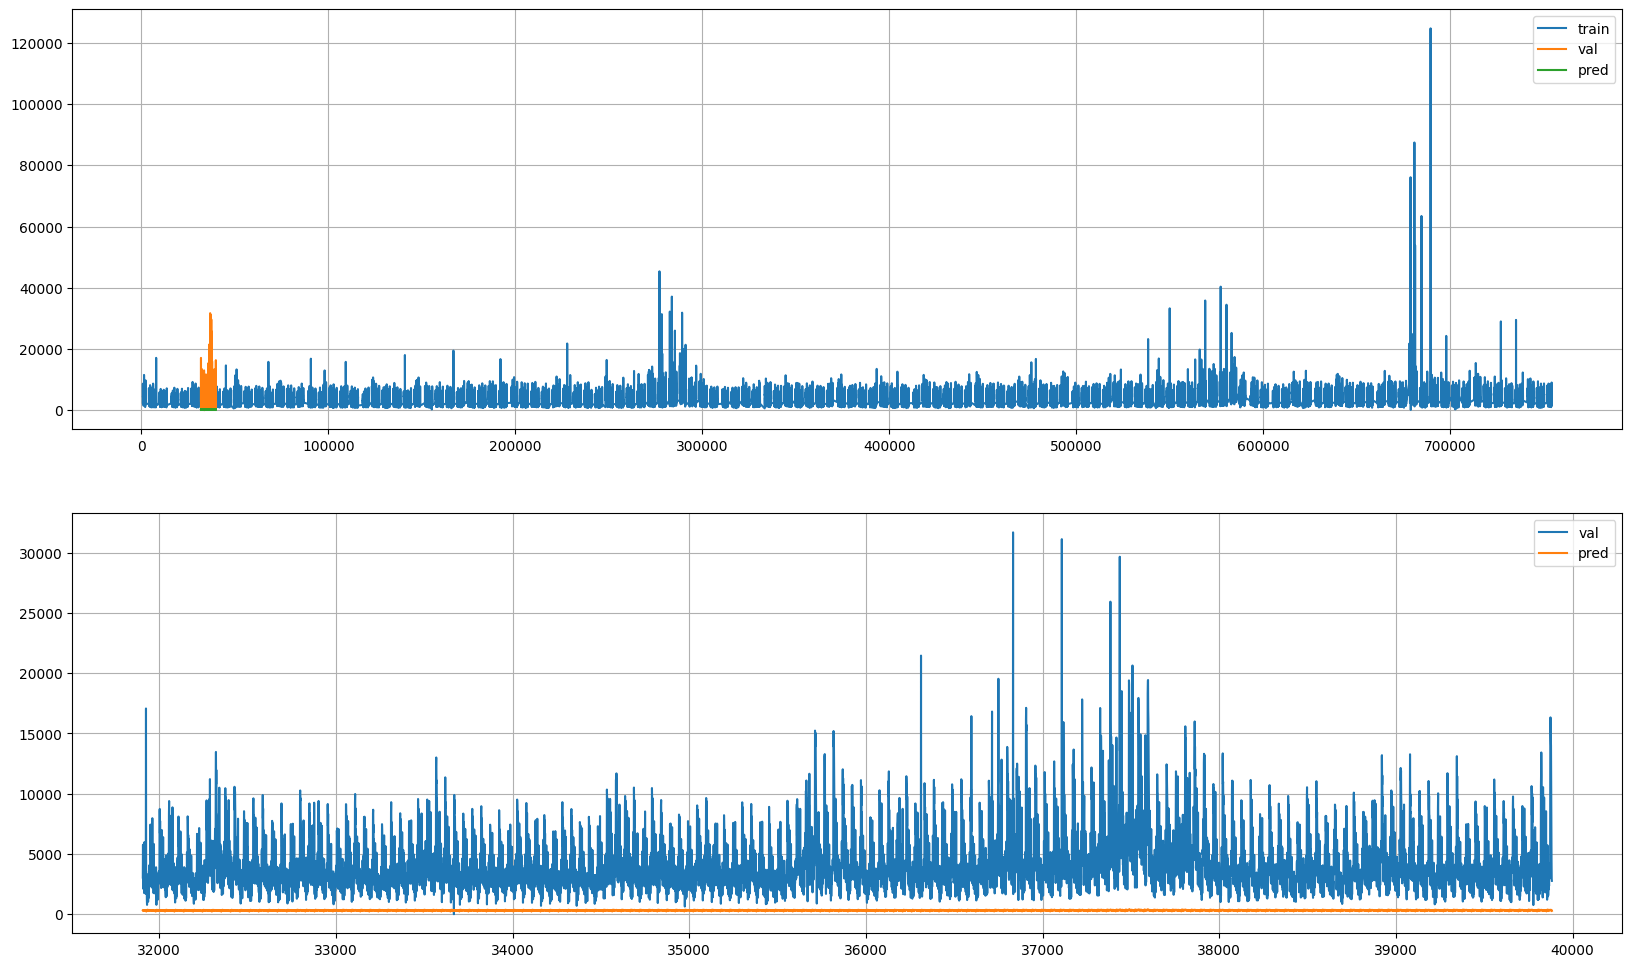

In [ ]:

# ### **2) 모델링**
clear_session()
model_food = Sequential()
model_food.add(Dense(1, input_dim=x_food_train.shape[1], activation='linear'))
model_food.compile(loss='mse', optimizer='adam')
history_food = model_food.fit(x_food_train, y_food_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_food_pred = model_food.predict(x_food_test)
y_food_pred = y_food_pred.reshape(-1,)
rmse_food = mean_squared_error(y_food_test, y_food_pred, squared=False)
mae_food = mean_absolute_error(y_food_test, y_food_pred)
mape_food = mean_absolute_percentage_error(y_food_test, y_food_pred)
r2_food = r2_score(y_food_test, y_food_pred)

print(f"Food Model Evaluation:")
print(f"RMSE: {rmse_food}")
print(f"MAE: {mae_food}")
print(f"MAPE: {mape_food}")
print(f"R2 Score: {r2_food}")

dl_history_plot(history_food.history)
plot_model_result(y_food_train, y_food_test, y_food_pred)


## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [ ]:
x_grocery = data_grocery.drop(columns=target, axis=1)
y_grocery = data_grocery[target]
x_grocery_train, x_grocery_test, y_grocery_train, y_grocery_test = train_test_split(x_grocery, y_grocery, test_size=0.2, shuffle=False, random_state=1)
# scaler_grocery = MinMaxScaler()
# scaler_grocery.fit(x_grocery_train)
# x_grocery_train = scaler_grocery.transform(x_grocery_train)
# x_grocery_test = scaler_grocery.transform(x_grocery_test)


### **2) 모델링**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Grocery Model Evaluation:
RMSE: 30.94840093191315
MAE: 25.042813475027025
MAPE: 0.2223915854833301
R2 Score: -0.47835915025314524


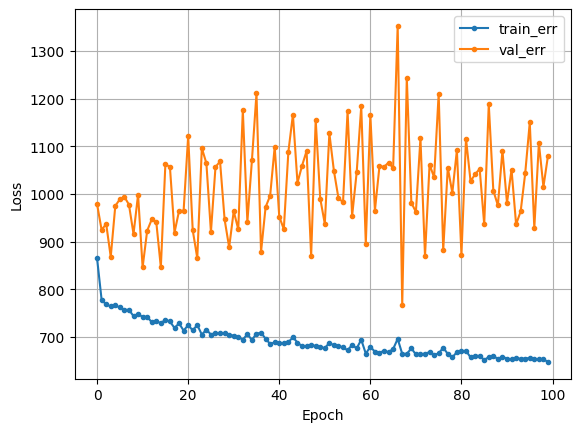

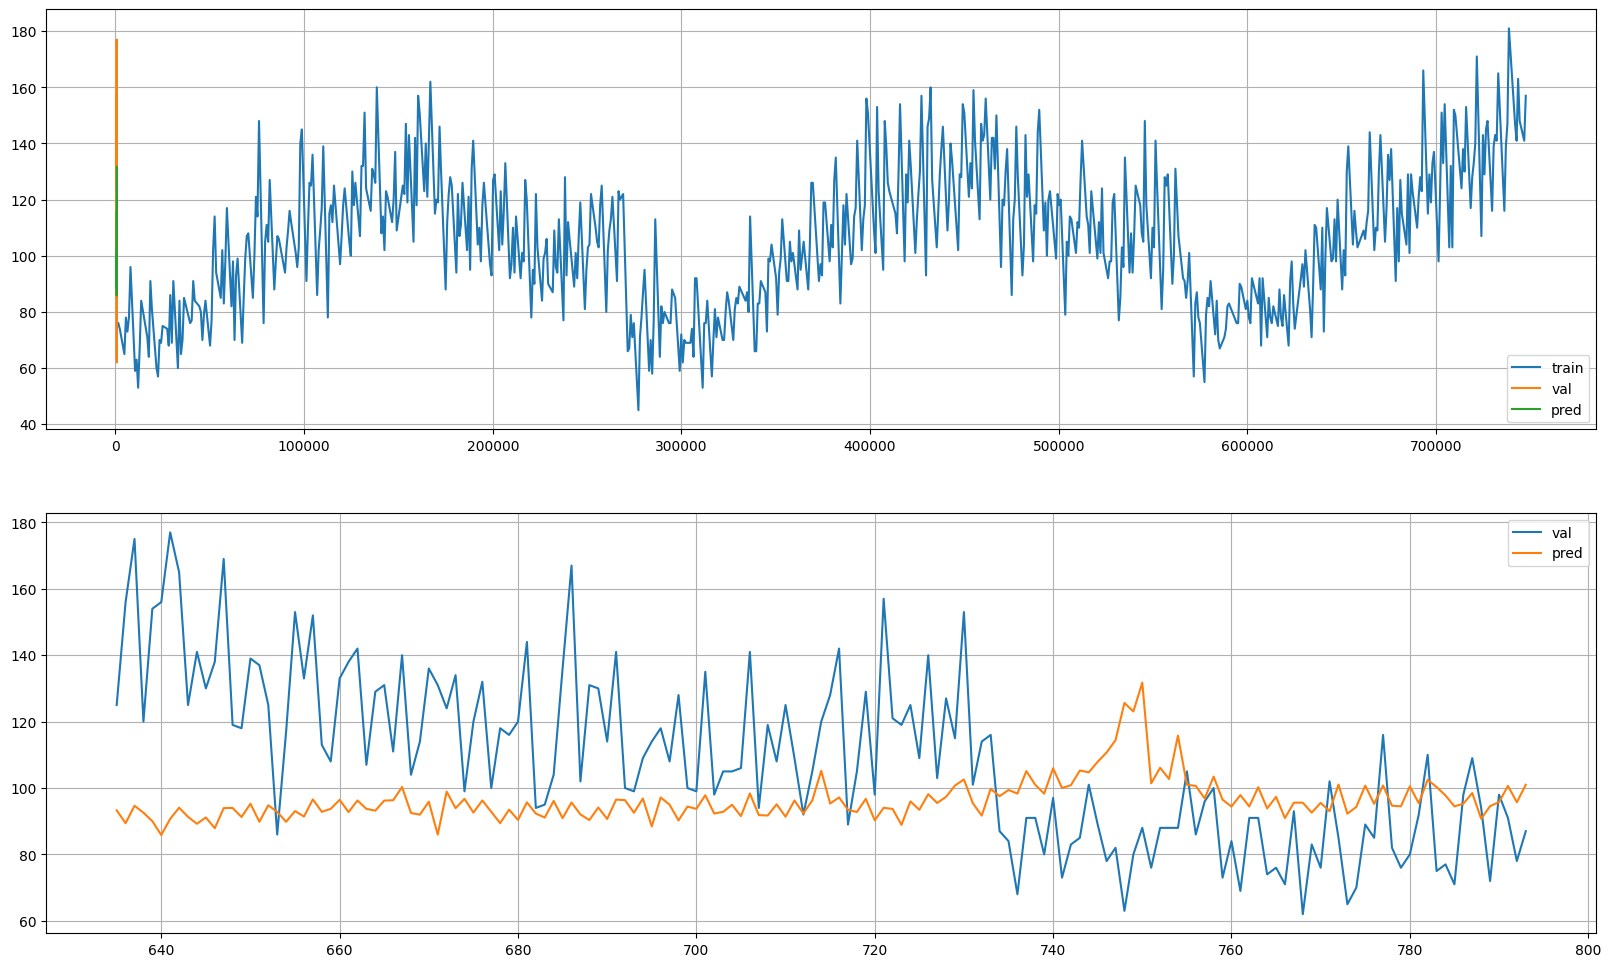

In [ ]:

# ### **2) 모델링**
clear_session()
model_grocery = Sequential()
model_grocery.add(Dense(1, input_dim=x_grocery_train.shape[1]))
model_grocery.compile(loss='mse', optimizer='adam')
history_grocery = model_grocery.fit(x_grocery_train, y_grocery_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_grocery_pred = model_grocery.predict(x_grocery_test).flatten()
# y_grocery_pred = y_grocery_pred.reshape(-1,)

rmse_grocery = mean_squared_error(y_grocery_test, y_grocery_pred, squared=False)
mae_grocery = mean_absolute_error(y_grocery_test, y_grocery_pred)
mape_grocery = mean_absolute_percentage_error(y_grocery_test, y_grocery_pred)
r2_grocery = r2_score(y_grocery_test, y_grocery_pred)

print(f"Grocery Model Evaluation:")
print(f"RMSE: {rmse_grocery}")
print(f"MAE: {mae_grocery}")
print(f"MAPE: {mape_grocery}")
print(f"R2 Score: {r2_grocery}")

dl_history_plot(history_grocery.history)
plot_model_result(y_grocery_train, y_grocery_test, y_grocery_pred)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [ ]:
data_beverage_grouped.drop(columns = ['Date'], inplace=True)
data_food_grouped.drop(columns = ['Date'], inplace=True)
data_grocery_grouped.drop(columns = ['Date'], inplace=True)

In [ ]:
x_beverage_2 = data_beverage_grouped.drop(columns=target, axis=1)
y_beverage_2 = data_beverage_grouped[target]
x_food_2 = data_food_grouped.drop(columns=target, axis=1)
y_food_2 = data_food_grouped[target]
x_grocery_2 = data_grocery_grouped.drop(columns=target, axis=1)
y_grocery_2 = data_grocery_grouped[target]

x_beverage_2, y_beverage_2 = temporalize(x_beverage_2, y_beverage_2, 2)
x_food_2, y_food_2 = temporalize(x_food_2, y_food_2, 2)
x_grocery_2, y_grocery_2 = temporalize(x_grocery_2, y_grocery_2, 2)

In [ ]:
x_beverage_2_train, x_beverage_2_test, y_beverage_2_train, y_beverage_2_test = train_test_split(x_beverage_2, y_beverage_2, test_size=0.2, random_state=1)
x_food_2_train, x_food_2_test, y_food_2_train, y_food_2_test = train_test_split(x_food_2, y_food_2, test_size=0.2, random_state=1)
x_grocery_2_train, x_grocery_2_test, y_grocery_2_train, y_grocery_2_test = train_test_split(x_grocery_2, y_grocery_2, test_size=0.2, random_state=1)


## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization


* **데이터 준비**

* **모델링**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
Beverage LSTM Model Evaluation:
RMSE: 38753.1009060748
MAE: 29834.098393278302
MAPE: 0.3094891941517838
R2 Score: 0.19465181960175748


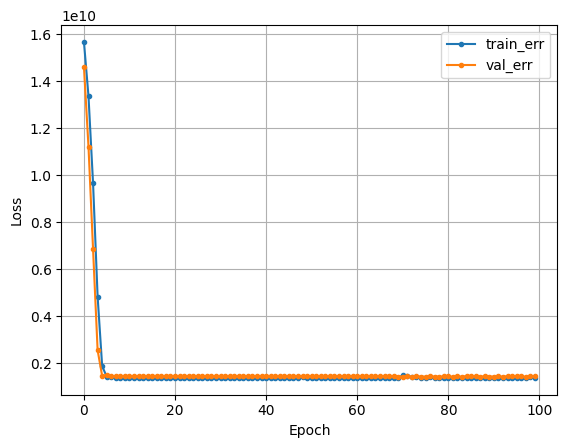

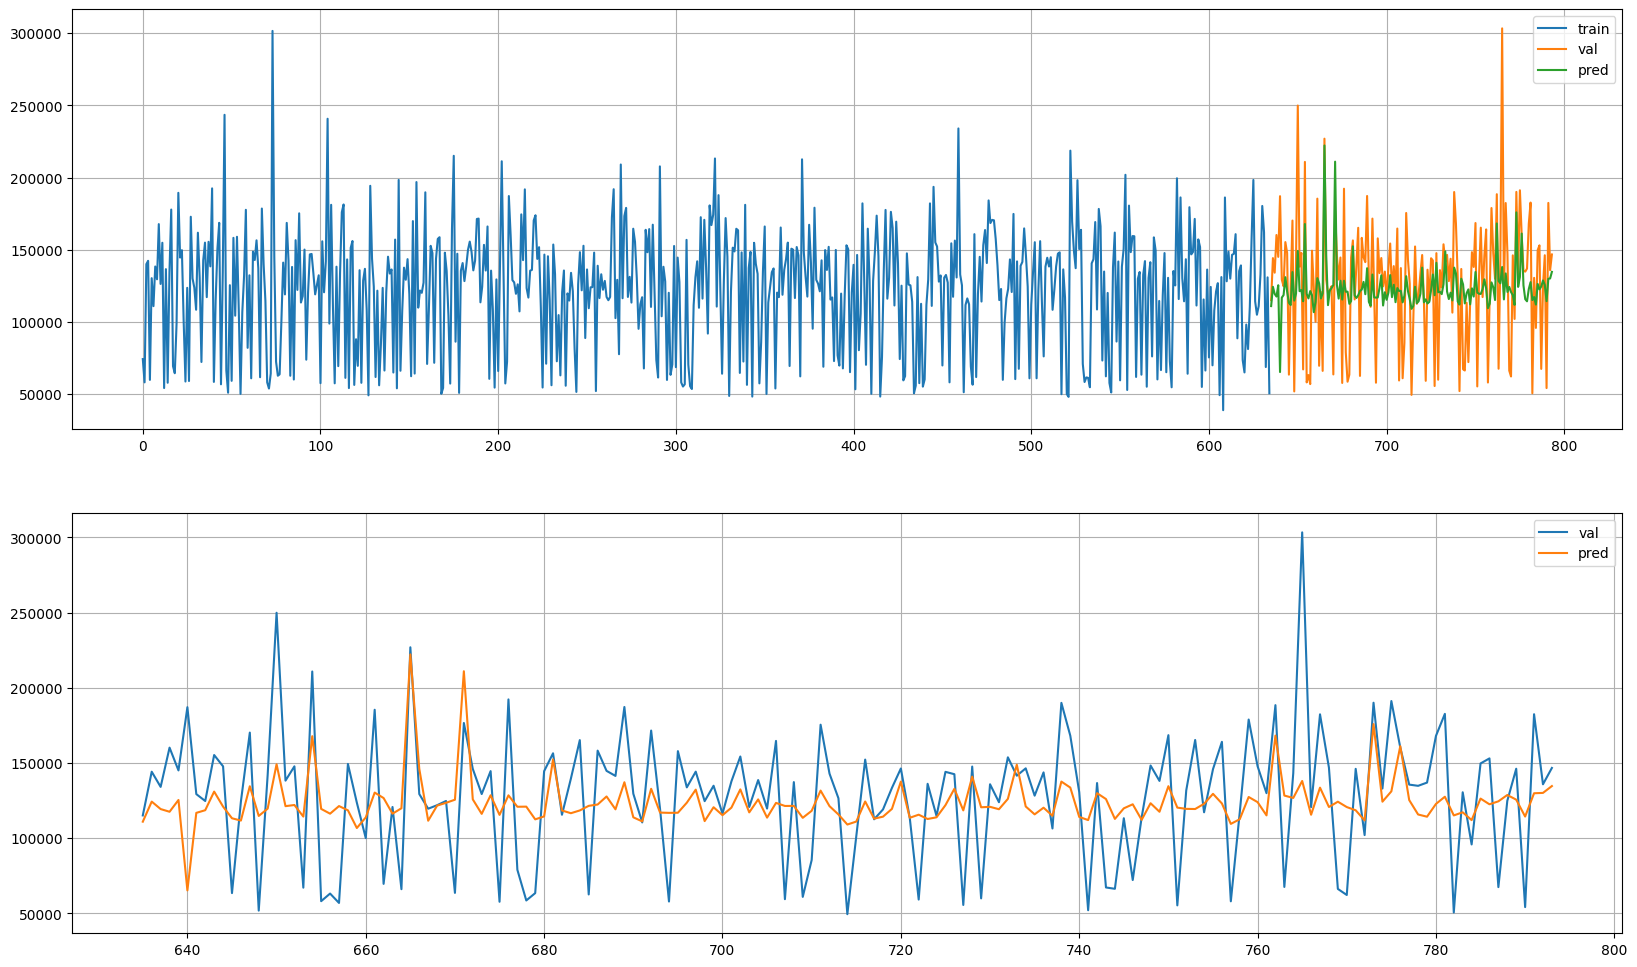

In [ ]:

# 모델링
clear_session()
model_beverage_lstm = Sequential()
model_beverage_lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_beverage_2_train.shape[1], x_beverage_2_train.shape[2])))

model_beverage_lstm.add(LSTM(50, activation='relu'))

model_beverage_lstm.add(Dense(25, activation='relu'))

model_beverage_lstm.add(Dense(1))
model_beverage_lstm.compile(loss='mse', optimizer='adam')

history_beverage_lstm = model_beverage_lstm.fit(x_beverage_2_train, y_beverage_2_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_beverage_2_pred_lstm = model_beverage_lstm.predict(x_beverage_2_test)

rmse_beverage_lstm = mean_squared_error(y_beverage_2_test, y_beverage_2_pred_lstm, squared=False)
mae_beverage_lstm = mean_absolute_error(y_beverage_2_test, y_beverage_2_pred_lstm)
mape_beverage_lstm = mean_absolute_percentage_error(y_beverage_2_test, y_beverage_2_pred_lstm)
r2_beverage_lstm = r2_score(y_beverage_2_test, y_beverage_2_pred_lstm)

print(f"Beverage LSTM Model Evaluation:")
print(f"RMSE: {rmse_beverage_lstm}")
print(f"MAE: {mae_beverage_lstm}")
print(f"MAPE: {mape_beverage_lstm}")
print(f"R2 Score: {r2_beverage_lstm}")

dl_history_plot(history_beverage_lstm.history)
plot_model_result(y_beverage_2_train, y_beverage_2_test, y_beverage_2_pred_lstm)


### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
Food LSTM Model Evaluation:
RMSE: 46629.99634678656
MAE: 28610.47796029874
MAPE: 0.13832538930059946
R2 Score: 0.3465492055582371


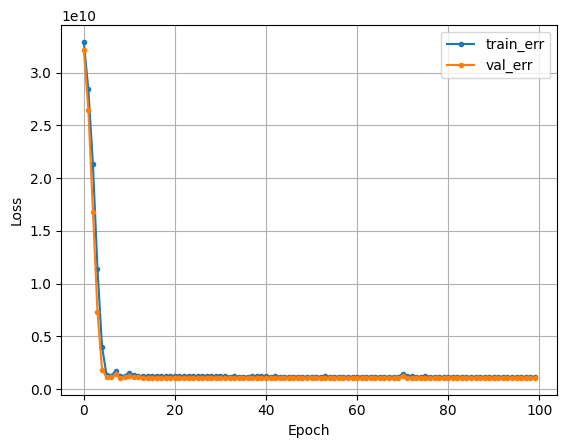

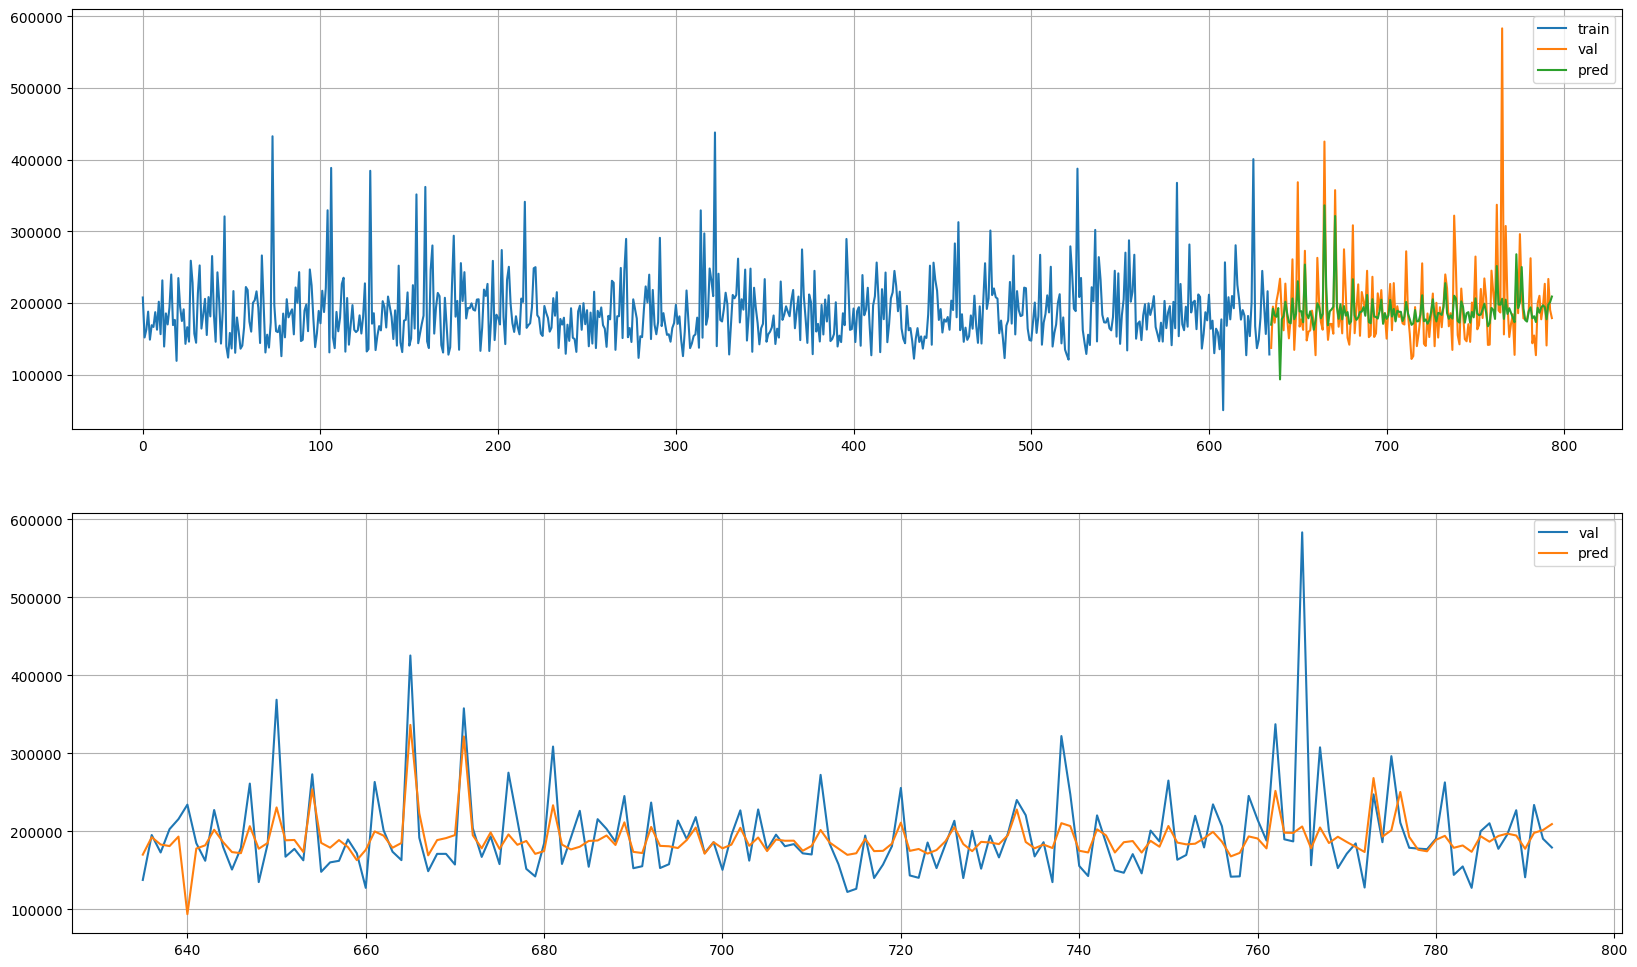

In [ ]:
# ### **2) 상품 : 12 - Milk**
# * **데이터 준비**
# * **모델링**

clear_session()
model_food_lstm = Sequential()
model_food_lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_food_2_train.shape[1], x_food_2_train.shape[2])))
model_food_lstm.add(LSTM(50, activation='relu'))
model_food_lstm.add(Dense(25, activation='relu'))
model_food_lstm.add(Dense(1))
model_food_lstm.compile(loss='mse', optimizer='adam')

history_food_lstm = model_food_lstm.fit(x_food_2_train, y_food_2_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_food_2_pred_lstm = model_food_lstm.predict(x_food_2_test)

rmse_food_lstm = mean_squared_error(y_food_2_test, y_food_2_pred_lstm, squared=False)
mae_food_lstm = mean_absolute_error(y_food_2_test, y_food_2_pred_lstm)
mape_food_lstm = mean_absolute_percentage_error(y_food_2_test, y_food_2_pred_lstm)
r2_food_lstm = r2_score(y_food_2_test, y_food_2_pred_lstm)

print(f"Food LSTM Model Evaluation:")
print(f"RMSE: {rmse_food_lstm}")
print(f"MAE: {mae_food_lstm}")
print(f"MAPE: {mape_food_lstm}")
print(f"R2 Score: {r2_food_lstm}")

dl_history_plot(history_food_lstm.history)
plot_model_result(y_food_2_train, y_food_2_test, y_food_2_pred_lstm)


### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Grocery LSTM Model Evaluation:
RMSE: 31.642541229158546
MAE: 23.885569158590066
MAPE: 0.2521249024202579
R2 Score: -0.8518044819662158


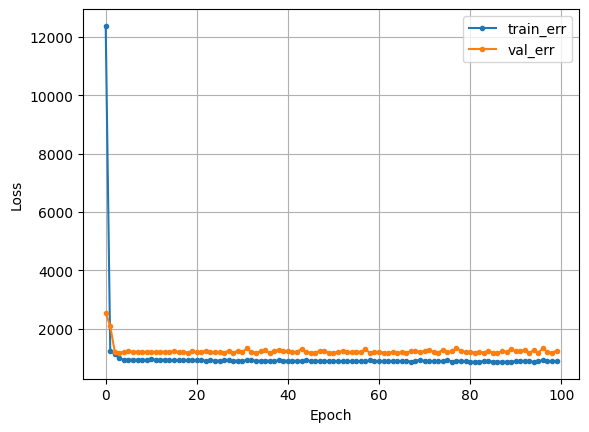

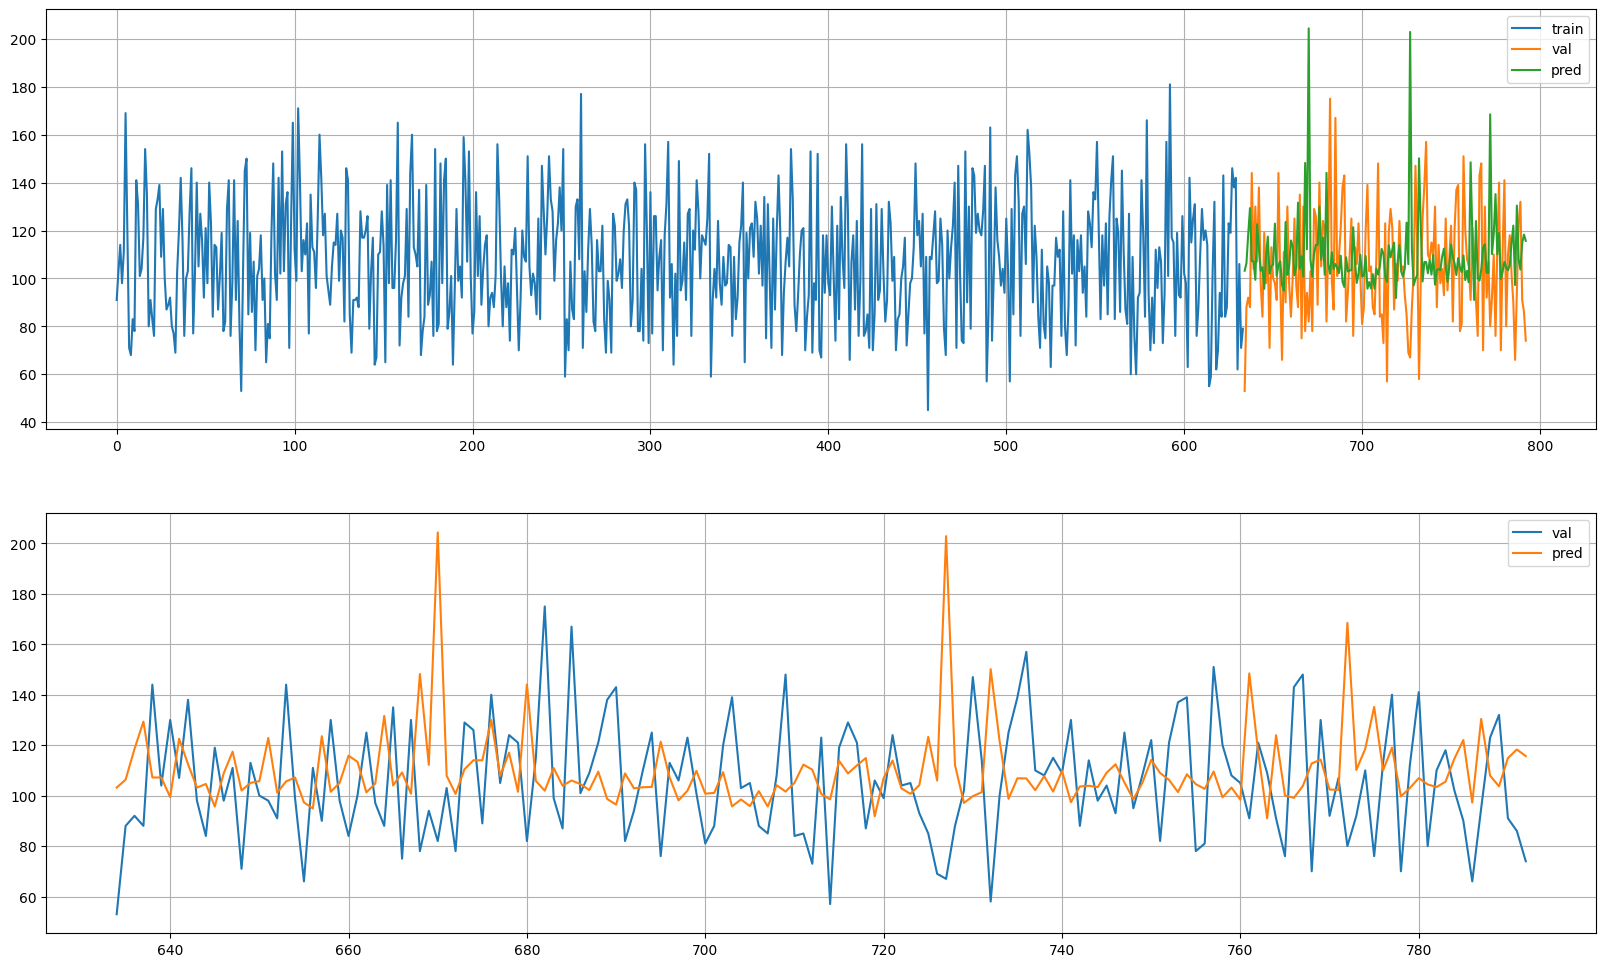

In [ ]:
# ### **3) 상품 : 42 - Agricultural products**
# * **데이터 준비**
# * **모델링**

clear_session()
model_grocery_lstm = Sequential()
model_grocery_lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_grocery_2_train.shape[1], x_grocery_2_train.shape[2])))
model_grocery_lstm.add(LSTM(50, activation='relu'))
model_grocery_lstm.add(Dense(25, activation='relu'))
model_grocery_lstm.add(Dense(1))
model_grocery_lstm.compile(loss='mse', optimizer='adam')

history_grocery_lstm = model_grocery_lstm.fit(x_grocery_2_train, y_grocery_2_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_grocery_2_pred_lstm = model_grocery_lstm.predict(x_grocery_2_test)

rmse_grocery_lstm = mean_squared_error(y_grocery_2_test, y_grocery_2_pred_lstm, squared=False)
mae_grocery_lstm = mean_absolute_error(y_grocery_2_test, y_grocery_2_pred_lstm)
mape_grocery_lstm = mean_absolute_percentage_error(y_grocery_2_test, y_grocery_2_pred_lstm)
r2_grocery_lstm = r2_score(y_grocery_2_test, y_grocery_2_pred_lstm)

print(f"Grocery LSTM Model Evaluation:")
print(f"RMSE: {rmse_grocery_lstm}")
print(f"MAE: {mae_grocery_lstm}")
print(f"MAPE: {mape_grocery_lstm}")
print(f"R2 Score: {r2_grocery_lstm}")

dl_history_plot(history_grocery_lstm.history)
plot_model_result(y_grocery_2_train, y_grocery_2_test, y_grocery_2_pred_lstm)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Beverage CNN Model Evaluation:
RMSE: 37452.73957075681
MAE: 29760.08254716981
MAPE: 0.3039972090584641
R2 Score: 0.24779200539937296


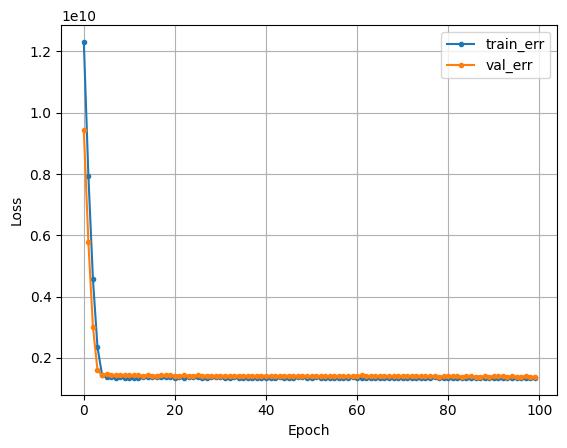

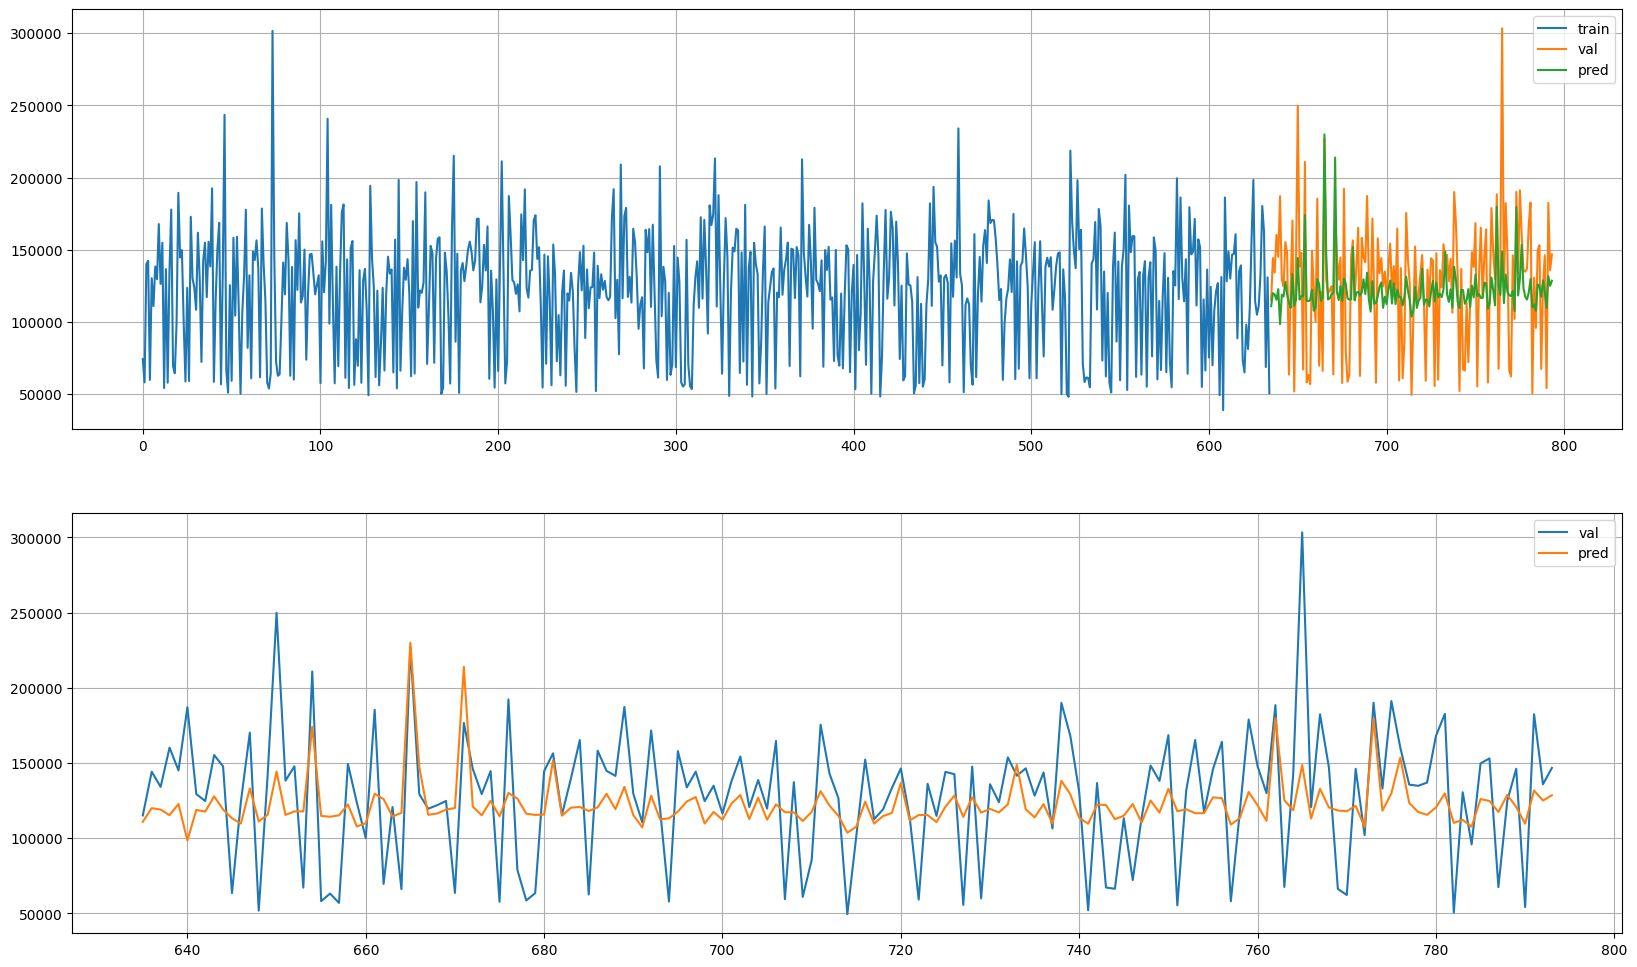

In [ ]:
# prompt: CNN 기반 모델링을 해봅시다
# 4개층으로

# ## **(1) CNN 초기 모델링**
# ### **1) 상품 : 3 - Beverage**
# * **데이터 준비**
# * **모델링**

clear_session()
model_beverage_cnn = Sequential()
model_beverage_cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(x_beverage_2_train.shape[1], x_beverage_2_train.shape[2])))
model_beverage_cnn.add(Flatten())
model_beverage_cnn.add(Dense(25, activation='relu'))
model_beverage_cnn.add(Dense(1))
model_beverage_cnn.compile(loss='mse', optimizer='adam')

history_beverage_cnn = model_beverage_cnn.fit(x_beverage_2_train, y_beverage_2_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_beverage_2_pred_cnn = model_beverage_cnn.predict(x_beverage_2_test)

rmse_beverage_cnn = mean_squared_error(y_beverage_2_test, y_beverage_2_pred_cnn, squared=False)
mae_beverage_cnn = mean_absolute_error(y_beverage_2_test, y_beverage_2_pred_cnn)
mape_beverage_cnn = mean_absolute_percentage_error(y_beverage_2_test, y_beverage_2_pred_cnn)
r2_beverage_cnn = r2_score(y_beverage_2_test, y_beverage_2_pred_cnn)

print(f"Beverage CNN Model Evaluation:")
print(f"RMSE: {rmse_beverage_cnn}")
print(f"MAE: {mae_beverage_cnn}")
print(f"MAPE: {mape_beverage_cnn}")
print(f"R2 Score: {r2_beverage_cnn}")

dl_history_plot(history_beverage_cnn.history)
plot_model_result(y_beverage_2_train, y_beverage_2_test, y_beverage_2_pred_cnn)



### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Food CNN Model Evaluation:
RMSE: 41888.881675518904
MAE: 25005.944930031445
MAPE: 0.11958622836497723
R2 Score: 0.47267342386449274


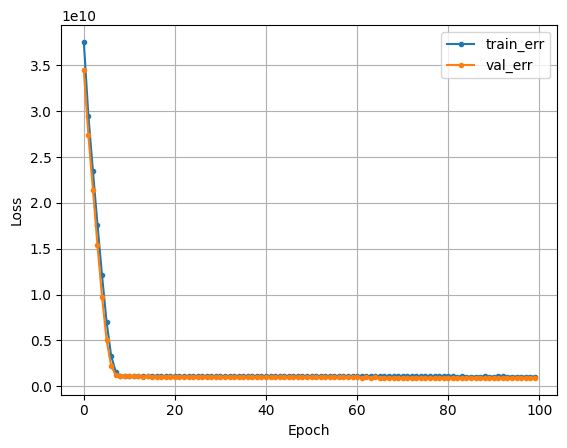

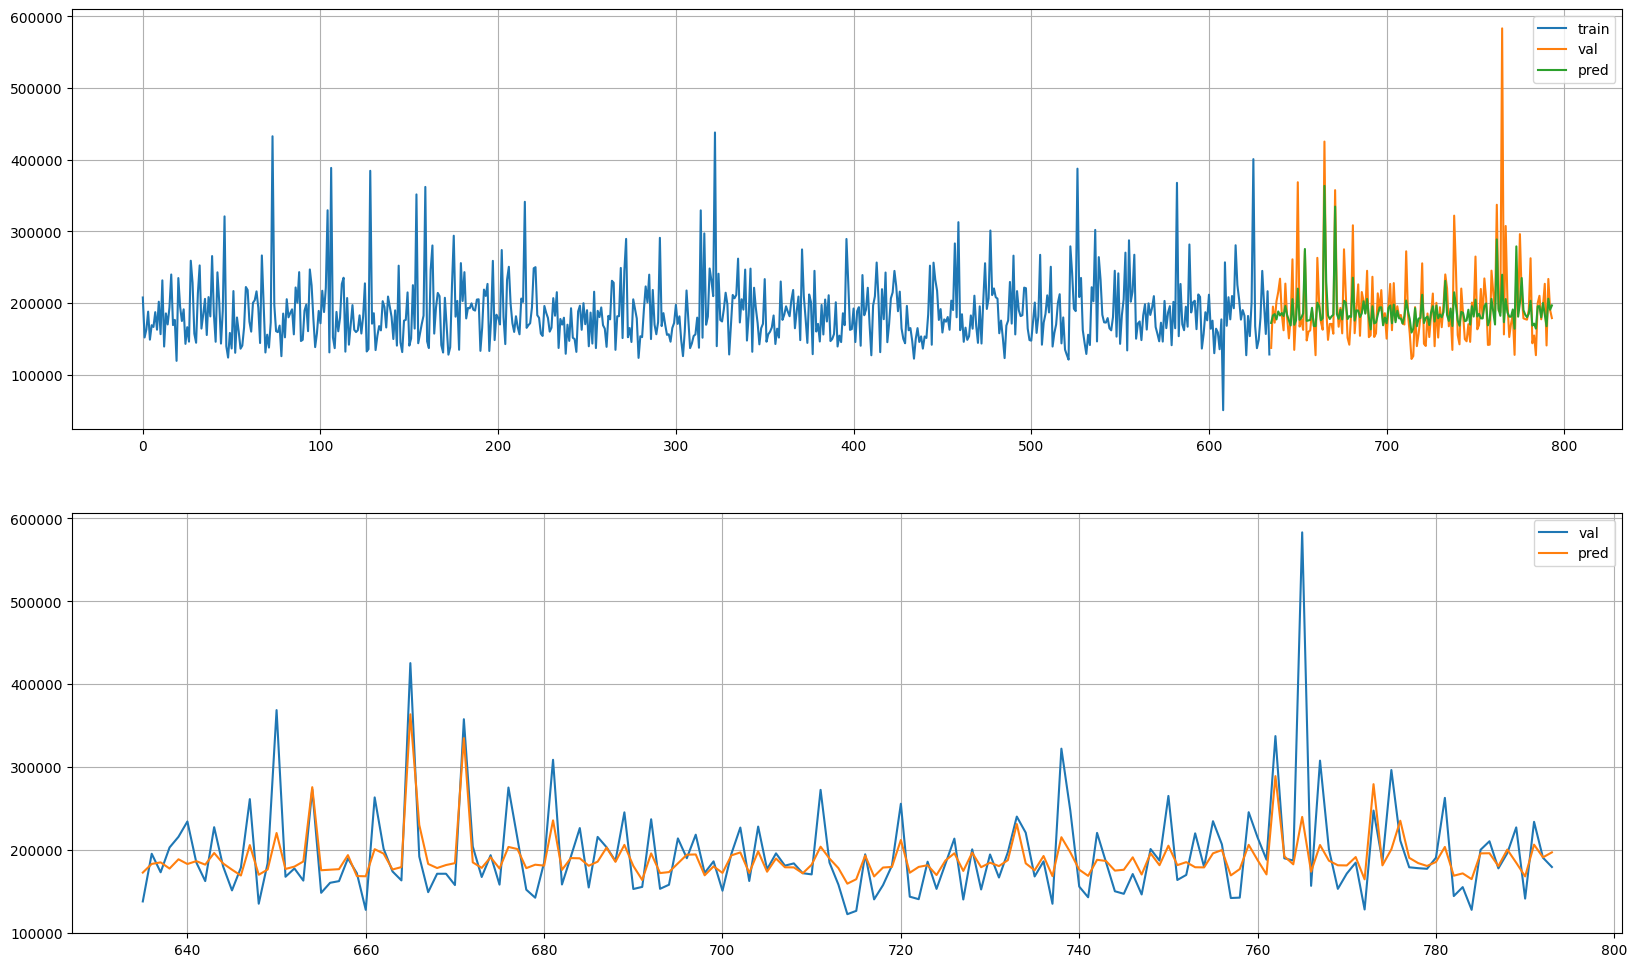

In [ ]:
# ### **2) 상품 : 12 - Milk**
# * **데이터 준비**
# * **모델링**
clear_session()
model_food_cnn = Sequential()
model_food_cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(x_food_2_train.shape[1], x_food_2_train.shape[2])))
model_food_cnn.add(Flatten())
model_food_cnn.add(Dense(25, activation='relu'))
model_food_cnn.add(Dense(1))
model_food_cnn.compile(loss='mse', optimizer='adam')

history_food_cnn = model_food_cnn.fit(x_food_2_train, y_food_2_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_food_2_pred_cnn = model_food_cnn.predict(x_food_2_test)

rmse_food_cnn = mean_squared_error(y_food_2_test, y_food_2_pred_cnn, squared=False)
mae_food_cnn = mean_absolute_error(y_food_2_test, y_food_2_pred_cnn)
mape_food_cnn = mean_absolute_percentage_error(y_food_2_test, y_food_2_pred_cnn)
r2_food_cnn = r2_score(y_food_2_test, y_food_2_pred_cnn)

print(f"Food CNN Model Evaluation:")
print(f"RMSE: {rmse_food_cnn}")
print(f"MAE: {mae_food_cnn}")
print(f"MAPE: {mape_food_cnn}")
print(f"R2 Score: {r2_food_cnn}")

dl_history_plot(history_food_cnn.history)
plot_model_result(y_food_2_train, y_food_2_test, y_food_2_pred_cnn)


### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Grocery CNN Model Evaluation:
RMSE: 31.377853318215724
MAE: 23.779400519604952
MAPE: 0.25295935293277183
R2 Score: -0.8209535956303127


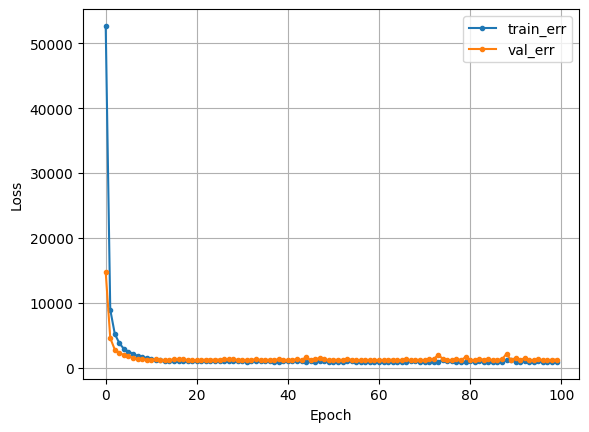

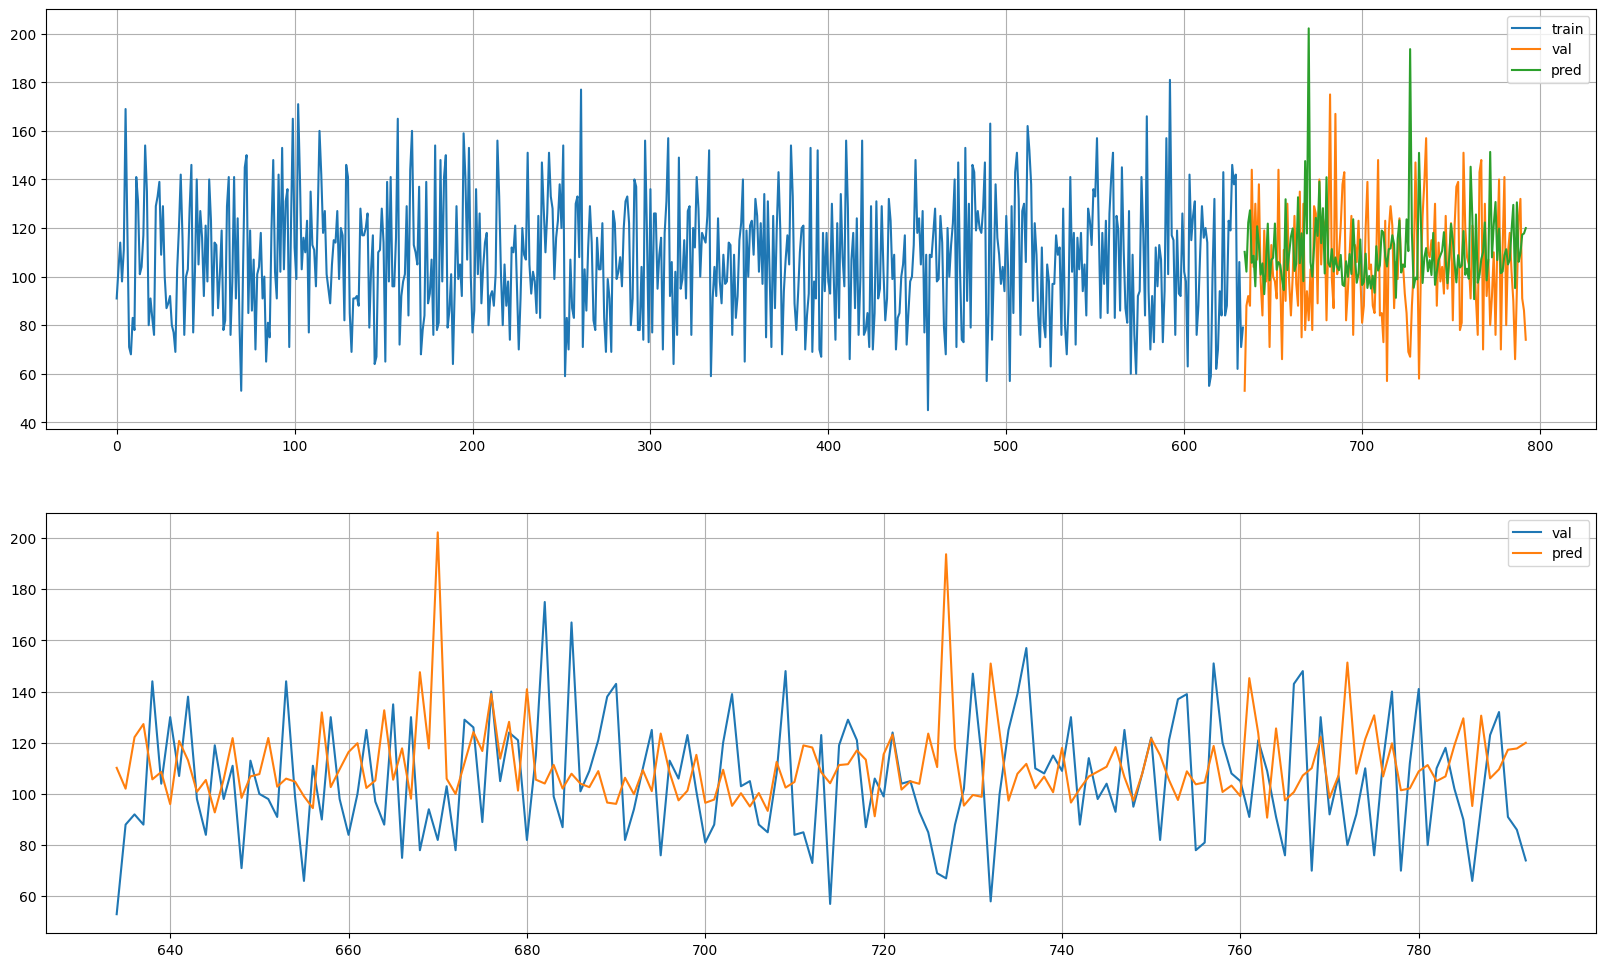

In [ ]:
# ### **3) 상품 : 42 - Agricultural products**
# * **데이터 준비**
# * **모델링**
clear_session()
model_grocery_cnn = Sequential()
model_grocery_cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(x_grocery_2_train.shape[1], x_grocery_2_train.shape[2])))
model_grocery_cnn.add(Flatten())
model_grocery_cnn.add(Dense(25, activation='relu'))
model_grocery_cnn.add(Dense(1))
model_grocery_cnn.compile(loss='mse', optimizer='adam')

history_grocery_cnn = model_grocery_cnn.fit(x_grocery_2_train, y_grocery_2_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_grocery_2_pred_cnn = model_grocery_cnn.predict(x_grocery_2_test)

rmse_grocery_cnn = mean_squared_error(y_grocery_2_test, y_grocery_2_pred_cnn, squared=False)
mae_grocery_cnn = mean_absolute_error(y_grocery_2_test, y_grocery_2_pred_cnn)
mape_grocery_cnn = mean_absolute_percentage_error(y_grocery_2_test, y_grocery_2_pred_cnn)
r2_grocery_cnn = r2_score(y_grocery_2_test, y_grocery_2_pred_cnn)

print(f"Grocery CNN Model Evaluation:")
print(f"RMSE: {rmse_grocery_cnn}")
print(f"MAE: {mae_grocery_cnn}")
print(f"MAPE: {mape_grocery_cnn}")
print(f"R2 Score: {r2_grocery_cnn}")

dl_history_plot(history_grocery_cnn.history)
plot_model_result(y_grocery_2_train, y_grocery_2_test, y_grocery_2_pred_cnn)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
# prompt: 세부 요구사항
# 상품코드별 데이터셋을 저장하시오.
# joblib.dump를 이용하시오.
# 저장할 파일의 확장자는 보통 .pkl 입니다.

# 상품코드별 데이터셋 저장
joblib.dump(data_beverage, 'data_beverage.pkl')
joblib.dump(data_food, 'data_food.pkl')
joblib.dump(data_grocery, 'data_grocery.pkl')
# 상품코드별 데이터셋 저장
joblib.dump(data_beverage_grouped, 'data_beverage.pkl')
joblib.dump(data_food_grouped, 'data_food.pkl')
joblib.dump(data_grocery_grouped, 'data_grocery.pkl')

['data_grocery.pkl']

In [ ]:
# prompt: 모델 lstm cnn 도 저장

# 모델 저장
model_beverage_lstm.save('model_beverage_lstm.h5')
model_food_lstm.save('model_food_lstm.h5')
model_grocery_lstm.save('model_grocery_lstm.h5')

model_beverage_cnn.save('model_beverage_cnn.h5')
model_food_cnn.save('model_food_cnn.h5')
model_grocery_cnn.save('model_grocery_cnn.h5')